In [2]:
import numpy
from matplotlib import pyplot
from scipy.constants import c

In [3]:
def window_function(u, u_0, sigma):
    return numpy.exp(-(u-u_0)**2.*sigma)

In [4]:
def averaged_window_function(u,u_offsets,sigma):
    offset_windows = numpy.array([window_function(u, u_i, sigma) for u_i in u_offsets])
    print(offset_windows.shape)
    
    averaged_window = numpy.mean(offset_windows, axis=0)
    print(averaged_window.shape)
    return averaged_window

In [5]:
def summed_window_function(u,u_offsets,sigma):
    offset_windows = numpy.array([window_function(u, u_i, sigma) for u_i in u_offsets])
    print(offset_windows.shape)
    
    summed_window = numpy.sum(offset_windows, axis=0)
    return summed_window

(4, 100)
(100,)
(4, 100)


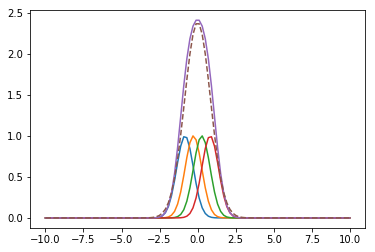

In [6]:
wavelength = 2.
x_coordinates = numpy.array([-1.5,-0.5,0.5,1.5])*1.1
u_offsets = x_coordinates/wavelength
width = (x_coordinates.max() - x_coordinates.min())/wavelength


u_coordinates = numpy.linspace(-10,10,100)

averaged_window = averaged_window_function(u_coordinates, u_offsets, width )
summed_window = summed_window_function(u_coordinates, u_offsets, width )



for offset in u_offsets:
    single = window_function(u_coordinates, offset, width)
    pyplot.plot(u_coordinates,single)

approximation = window_function(u_coordinates, 0, width*0.42)/0.42

#pyplot.plot(u_coordinates, averaged_window)
pyplot.plot(u_coordinates, summed_window)
pyplot.plot(u_coordinates, approximation, linestyle='--')

In [51]:
def beam_width(frequency, diameter= 4, epsilon = 1):
    return epsilon*c/(frequency*diameter)

## Can I Object Orientify my SCAR code?

In [8]:
class PointSourceSky:
    
    def __init__(self):
        self.flux_0 = None
        self.frequency_0 = None
        self.l_coordinate = None
        self.m_coordinate = None
        self.spectral_index = 0.8
        
        
    def add_source(self, flux, frequency_0 = 150e6, l_coordinate = 0, m_coordinate =0 , spectral_index=0.8):
        assert isinstance(flux, numpy.ndarray), "Please input a numpy array for flux"
        assert isinstance(frequency_0, numpy.ndarray), "Please input a numpy array for frequency"
        assert isinstance(l_coordinate, numpy.ndarray), "Please input a numpy array l coordinate"
        assert isinstance(m_coordinate, numpy.ndarray), "Please input a numpy array m coordinate"
        assert isinstance(spectral_index, numpy.ndarray), "Please input a numpy array spectral index"

        if self.flux_0 == None:
            self.flux_0 = flux
            self.frequency_0 = frequency_0
            self.l_coordinate = l_coordinate
            self.m_coordinate = m_coordinate
            self.spectral_index = spectral_index
        else:
            self.flux_0.append(flux)
            self.frequency_0.append(frequency_0)
            self.l_coordinate.append(l_coordinate)
            self.m_coordinate.append(m_coordinate)
            self.spectral_index.append(spectral_index)
        return
            
    

## The analytical Covariance Expression

In [61]:
def visibility_model(u,v, frequency1, sources):
    visibilities = numpy.zeros(frequency1.shape, dtype=complex)
    nu_low = numpy.min(frequency1)
    for i in range(len(sources.flux_0)):
        source_l = sources.l_coordinate[i]
        source_m = sources.m_coordinate[i]
        
        beam_response = numpy.exp(-(source_l**2. +  source_m**2.)/beam_width(frequency1))
        fourier_kernel= numpy.exp(-2*numpy.pi*1j*(source_l*u + source_m*v)*frequency1/nu_low)
        visibilities += sources.flux_0[i]*(frequency1/nu_low)**-0.8*beam_response*fourier_kernel
    return visibilities

def visibility_perturbation(u,v, frequency1, sources):
    perturbation = numpy.zeros(frequency1.shape, dtype=complex)
    nu_low = numpy.min(frequency1)
    for i in range(len(sources.flux_0)):
        source_l = sources.l_coordinate[i]
        source_m = sources.m_coordinate[i]
        beam_response = numpy.exp(-(sources.source_l**2. +  sources.m_coordinate[i]**2.)/beamwidth(frequency1))
        fourier_kernel= numpy.exp(-2*numpy.pi*1j*(source_l*u + source_m*v)*frequency1/nu_low)
        visibility = sources.flux_0[i]*(frequency1/nu_low)**-0.8*beam_response*fourier_kernel
        perturbation_phase = numpy.exp(2*numpy.pi*1j*sources.l_coordinate)
        perturbation += visibility
    

def beam_covariance(u ,v, nu1, nu2 , sources):
    #nu_low = numpy.min(nu1)
    #dx = 1.1
    #beam_1 = beam_width(nu1)
    #beam_2 = beam_width(nu2)
    
    #Sigma = (beam_1**2.+ beam_2**2.)/(beam_1*beam_2)
    
    
    
    #source_flux = S_0*(nu1*nu2/nu_low**2.)**-spectral_index
    #beam_attenuation = numpy.exp(-source_l**2.*Sigma)
    
    
    
    
    
    #VdV = numpy.exp(-2*numpy.pi*1j*u*source_l/nu_low*(nu1-nu2))*numpy.exp(4*numpy.pi*1j*source_l/beam_2)*\
    #((numpy.exp(-2*numpy.pi*1j*source_l/beam_2) - 1)**2./(numpy.exp(2*numpy.pi*1j*dx*nu2*source_l/c) - 1)**2.)
    
    #dVV = numpy.exp(2*numpy.pi*1j*u*source_l/nu_low*(nu1-nu2))*numpy.exp(-4*numpy.pi*1j*source_l/beam_1)*\
    #((numpy.exp(2*numpy.pi*1j*source_l/beam_1) - 1)**2./(numpy.exp(2*numpy.pi*1j*dx*nu1*source_l/c) - 1)**2.)
    
    #C = source_l*beam_attenuation*(VdV + dVV)
    
    source_model1 = visibility_model(u,v, nu1, sources)
    source_model2 = visibility_model(u,v, nu2, sources)
    
    source_pert1 = dV(u, v, nu1, sources)
    source_pert2 = dV(u, v, nu2, sources)

    C = source_model1*numpy.conj(source_pert2) + numpy.conj(source_model2)*source_pert2
    
    
    return C


def dV(u, v, nu, sources):
    D = 4
    dx= 1.1
    wavelength =  c/nu

    sigma = beam_width(nu)
    visibility_perturbation = numpy.zeros_like(nu, dtype = complex)
    for source_index in range(len(sources.flux_0)):
        source_l = sources.l_coordinate[source_index]
        source_m = sources.m_coordinate[source_index]
        source_S = sources.flux_0[source_index]
        
        beam_attenuation = numpy.exp(-(source_l**2. + source_m**2.)/sigma**2.)
        source_visibility= source_S*numpy.exp(-2.*numpy.pi*1j*(u*source_l + v*source_m))
        dipole_factor = numpy.exp(-2.*numpy.pi*1j*(source_l + source_m)*D/(2*wavelength))
        
        dipole_fraction= (numpy.exp(2*numpy.pi*1j*source_l*D/wavelength) - 1)/\
            (numpy.exp(2*numpy.pi*1j*source_l*dx/wavelength) - 1)*\
            (numpy.exp(2*numpy.pi*1j*source_m*D/wavelength) - 1)/\
            (numpy.exp(2*numpy.pi*1j*source_m*dx/wavelength) - 1)
        
        visibility_perturbation += source_visibility*beam_attenuation*dipole_factor*dipole_fraction
    
    return visibility_perturbation
        
        
    
    

In [62]:
flux = numpy.array([100])
frequency_0 = numpy.array([150e6])
source_l = numpy.array([0])
source_m = numpy.array([0])
spectral_index = numpy.array([0.8])


sky_model = PointSourceSky()
sky_model.add_source(flux, frequency_0, source_l, source_m, spectral_index)

In [63]:
frequency_range = numpy.linspace(140, 170, 100)*1e6


In [64]:
u_eor = 50
ff1, ff2 = numpy.meshgrid(frequency_range, frequency_range)

analytic_covariance = beam_covariance(u_eor, u_eor, ff1, ff2, sky_model)

/home/ronniyjoseph/Software/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:79: RuntimeWarning: invalid value encountered in true_divide


[[nan+nanj nan+nanj nan+nanj ... nan+nanj nan+nanj nan+nanj]
 [nan+nanj nan+nanj nan+nanj ... nan+nanj nan+nanj nan+nanj]
 [nan+nanj nan+nanj nan+nanj ... nan+nanj nan+nanj nan+nanj]
 ...
 [nan+nanj nan+nanj nan+nanj ... nan+nanj nan+nanj nan+nanj]
 [nan+nanj nan+nanj nan+nanj ... nan+nanj nan+nanj nan+nanj]
 [nan+nanj nan+nanj nan+nanj ... nan+nanj nan+nanj nan+nanj]]


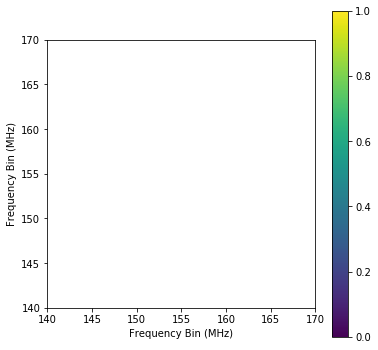

In [67]:
print(analytic_covariance)


figure = pyplot.figure(figsize = (6,6))
covariance_plot = figure.add_subplot(111)
cov_h = covariance_plot.pcolor(frequency_range/1e6, frequency_range/1e6,numpy.abs(analytic_covariance))
covariance_plot.set_xlabel('Frequency Bin (MHz)')
covariance_plot.set_ylabel('Frequency Bin (MHz)')
figure.colorbar(cov_h)

covariance_plot.set_aspect('equal')

## Compare with numerical covariance

In [14]:
import numpy
import powerbox
import time
import numexpr
from scipy import interpolate

from matplotlib import pyplot
from matplotlib.widgets import Slider
from scipy.constants import c as light_speed

import sys
sys.path.append('../../../redundant_calibration/code/SCAR')
from RadioTelescope import antenna_gain_creator
from RadioTelescope import baseline_converter
from RadioTelescope import xyz_position_creator
from SkyModel import flux_list_to_sky_image
from SkyModel import flux_distribution
from quick_simulation_visibility_covariance import lm_to_theta_phi
from quick_simulation_visibility_covariance import mwa_tile_beam
from quick_simulation_visibility_covariance import interactive_frequency_plotter
from quick_simulation_visibility_covariance import visibility_beam_covariance

In [22]:
# create array
sky_param = ['point', 200, 0.1, 0.]
noise_param = [False, 20e3, 40e3, 120]
beam_param = ['gaussian', 0.25, 0.25]
# telescope_param = ["hex", 14., 0, 0]
telescope_param = ["linear", 10, 5, 0]
sky_seed = 0

calculate_covariance = True

In [23]:
if calculate_covariance:
    visibility_realisations = visibility_beam_covariance(telescope_param, frequency_range, sky_param)


Creating x- y- z-positions of a 5 element linear array

Converting xyz to uvw-coordinates

Number of antenna = 5
Total number of baselines = 10
Creating the sky



/home/ronniyjoseph/Sync/PhD/Projects/hybrid_calibration/code/tile_beam_perturbations/quick_simulation_visibility_covariance.py:206: RuntimeWarning: invalid value encountered in arcsin
  theta = numpy.arcsin(numpy.sqrt(ll ** 2. + mm ** 2.))
/home/ronniyjoseph/Sync/PhD/Projects/hybrid_calibration/code/tile_beam_perturbations/quick_simulation_visibility_covariance.py:207: RuntimeWarning: divide by zero encountered in true_divide
  phi = numpy.arctan(mm / ll)
/home/ronniyjoseph/Sync/PhD/Projects/hybrid_calibration/code/tile_beam_perturbations/quick_simulation_visibility_covariance.py:207: RuntimeWarning: invalid value encountered in true_divide
  phi = numpy.arctan(mm / ll)
/home/ronniyjoseph/Sync/PhD/Projects/hybrid_calibration/code/tile_beam_perturbations/quick_simulation_visibility_covariance.py:207: RuntimeWarning: invalid value encountered in arctan
  phi = numpy.arctan(mm / ll)


Creating the idealised MWA beam

Iterating of 16 realisations of a perturbed MWA beam
Extracting visibilities per frequency channel

Extracting visibilities per frequency channel

Extracting visibilities per frequency channel

Extracting visibilities per frequency channel

Extracting visibilities per frequency channel

Extracting visibilities per frequency channel

Extracting visibilities per frequency channel

Extracting visibilities per frequency channel

Extracting visibilities per frequency channel

Extracting visibilities per frequency channel

Extracting visibilities per frequency channel

Extracting visibilities per frequency channel

Extracting visibilities per frequency channel

Extracting visibilities per frequency channel

Extracting visibilities per frequency channel

Extracting visibilities per frequency channel

Calculating the covariance matrix for a single baseline over the frequency range


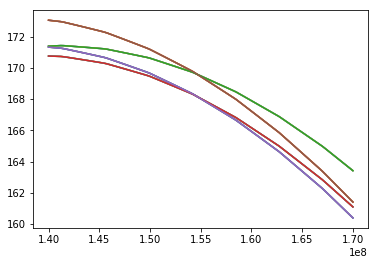

In [28]:
pyplot.plot(frequency_range, numpy.real(visibility_realisations))

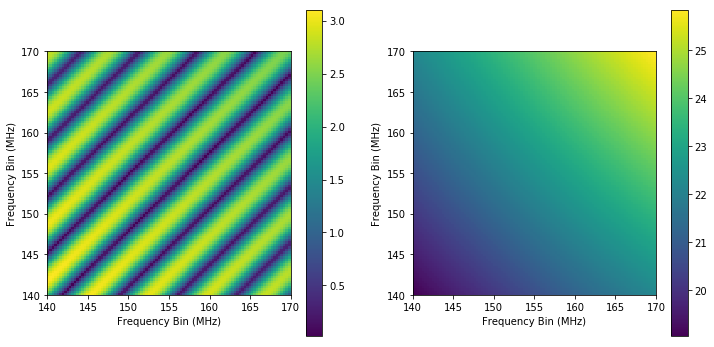

In [26]:
numerical_covariance = numpy.cov(visibilyt_realisations)

if calculate_covariance:
    %matplotlib inline
    figure = pyplot.figure(figsize = (12,6))
    a_covariance_plot = figure.add_subplot(121)
    analytic_plot = a_covariance_plot.pcolor(frequency_range/1e6, frequency_range/1e6,numpy.abs(analytic_covariance))
    a_covariance_plot.set_xlabel('Frequency Bin (MHz)')
    a_covariance_plot.set_ylabel('Frequency Bin (MHz)')
    a_covariance_plot.set_aspect('equal')


    n_covariance_plot = figure.add_subplot(122)
    numerical_plot = n_covariance_plot.pcolor(frequency_range/1e6, frequency_range/1e6,numpy.abs(numerical_covariance))
    n_covariance_plot.set_xlabel('Frequency Bin (MHz)')
    n_covariance_plot.set_ylabel('Frequency Bin (MHz)')
    figure.colorbar(analytic_plot, ax = a_covariance_plot)
    figure.colorbar(numerical_plot, ax = n_covariance_plot)

    n_covariance_plot.set_aspect('equal')
    pyplot.show()

## Debugging the code

In [81]:
def visibility_extractor(baseline_table, sky_cube, antenna1_response, antenna2_response):
    apparent_sky = sky_cube*antenna1_response*numpy.conj(antenna2_response)
    padding_factor = 3
    
    padded_sky = numpy.pad(apparent_sky, padding_factor*len(apparent_sky), mode = "constant")
    shifted_image = numpy.fft.ifftshift(padded_sky,  axes=(0, 1))
    visibility_grid, uv_coordinates = powerbox.dft.fft(shifted_image, L=2*(2*padding_factor + 1),  axes=(0, 1))
    
    measured_visibilities = uv_list_to_baseline_measurements(baseline_table,visibility_grid, uv_coordinates)
    return measured_visibilities

In [72]:
def uv_list_to_baseline_measurements(baseline_table, visibility_grid, uv_grid):
    n_measurements = baseline_table.shape[0]
    
    u_bin_size = numpy.median(numpy.diff(uv_grid[0]))
    v_bin_size = numpy.median(numpy.diff(uv_grid[1]))
 

    #pyplot.pcolor(uv_grid[0], uv_grid[1], numpy.abs(visibility_grid))
    #pyplot.show()

    u_bin_centers = uv_grid[0] 
    v_bin_centers = uv_grid[1]
    
    
    #now we have the bin edges we can start binning our baseline table
    #Create an empty array to store our baseline measurements in
    visibility_data = visibility_grid
    
    real_component = interpolate.RegularGridInterpolator((u_bin_centers, v_bin_centers), numpy.real(visibility_data))
    imag_component = interpolate.RegularGridInterpolator((u_bin_centers, v_bin_centers), numpy.imag(visibility_data))
    visibilities = real_component(baseline_table[:, 2:4]) + \
                                           1j*imag_component(baseline_table[:, 2:4])
    
    #uu, vv = numpy.meshgrid(uv_grid[0], uv_grid[1])
    
    #real_component = interpolate.griddata((uu.flatten(), vv.flatten()), numpy.real(visibility_data.flatten()), (baseline_table[:, 2], baseline_table[:, 3]), method='cubic' )
    #imag_component = interpolate.griddata((uu.flatten(), vv.flatten()), numpy.imag(visibility_data.flatten()), (baseline_table[:, 2],  baseline_table[:, 3]), method='cubic')
    
    
    #visibilities = real_component + 1j*imag_component

    return visibilities

def uv_list_to_baseline_measurements_interp(baseline_table, visibility_grid, uv_grid):
    n_measurements = baseline_table.shape[0]
    
    u_bin_size = numpy.median(numpy.diff(uv_grid[0]))
    v_bin_size = numpy.median(numpy.diff(uv_grid[1]))
    
    u_bin_centers = uv_grid[0] - u_bin_size/2.
    v_bin_centers = uv_grid[1] - v_bin_size/2.
    
    #now we have the bin edges we can start binning our baseline table
    #Create an empty array to store our baseline measurements in
    visibility_data = visibility_grid
    
    real_component = interpolate.interp2d(u_bin_centers, v_bin_centers, numpy.real(visibility_data), kind ='quintic')
    imag_component = interpolate.interp2d(u_bin_centers, v_bin_centers, numpy.imag(visibility_data), kind ='quintic')

    visibilities = real_component(baseline_table[:, 2], baseline_table[:, 3]) + \
            1j*imag_component(baseline_table[:, 2], baseline_table[:, 3])
    
    return visibilities

In [116]:
# create array
sky_param = ['single', 200, 0.99, 0.]
noise_param = [False, 20e3, 40e3, 120]
beam_param = ['gaussian', 0.25, 0.25]
# telescope_param = ["hex", 14., 0, 0]
telescope_param = ["linear", 50, 5, 0]
sky_seed = 0

In [117]:
xyz_positions = xyz_position_creator(telescope_param)
gain_table = antenna_gain_creator(xyz_positions, frequency_range)
baseline_table = baseline_converter(xyz_positions, gain_table, frequency_range)

if sky_param[0] == 'random':
    all_flux, all_l, all_m = flux_distribution(['random', sky_seed])
elif sky_param[0] == 'single':
    all_flux, all_l, all_m = flux_distribution(sky_param)
point_source_list = numpy.stack((all_flux, all_l, all_m), axis=1)

baseline_index = 0
baseline_selection = numpy.array([baseline_table[baseline_index]])

sky_cube, l_coordinates, m_coordinates = flux_list_to_sky_image(point_source_list, baseline_selection)


Creating x- y- z-positions of a 5 element linear array

Converting xyz to uvw-coordinates

Number of antenna = 5
Total number of baselines = 10


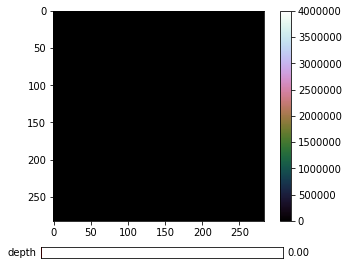

In [118]:
interactive_frequency_plotter(sky_cube)

In [92]:
ll, mm, ff = numpy.meshgrid(l_coordinates, m_coordinates, frequency_range)
tt, pp, = lm_to_theta_phi(ll, mm)

/home/ronniyjoseph/Sync/PhD/Projects/hybrid_calibration/code/tile_beam_perturbations/quick_simulation_visibility_covariance.py:177: RuntimeWarning: invalid value encountered in arcsin
  theta = numpy.arcsin(numpy.sqrt(ll ** 2. + mm ** 2.))
/home/ronniyjoseph/Sync/PhD/Projects/hybrid_calibration/code/tile_beam_perturbations/quick_simulation_visibility_covariance.py:178: RuntimeWarning: divide by zero encountered in true_divide
  phi = numpy.arctan(mm / ll)
/home/ronniyjoseph/Sync/PhD/Projects/hybrid_calibration/code/tile_beam_perturbations/quick_simulation_visibility_covariance.py:178: RuntimeWarning: invalid value encountered in true_divide
  phi = numpy.arctan(mm / ll)
/home/ronniyjoseph/Sync/PhD/Projects/hybrid_calibration/code/tile_beam_perturbations/quick_simulation_visibility_covariance.py:178: RuntimeWarning: invalid value encountered in arctan
  phi = numpy.arctan(mm / ll)


#### This is very a realised I shouldn't pass along the frequency channels as pointing centers!

In [25]:
ideal_beam = mwa_tile_beam(tt, pp, frequency=ff)

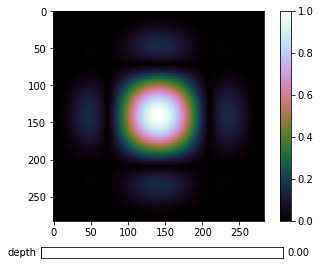

In [26]:
interactive_frequency_plotter(numpy.abs(ideal_beam))

### I now do the FFT and the baseline extraction at the frequency level, because it becomes to computationally heavy.

So for some reason I interpolated between the uv_grid edges, rather than the bin centers. (Laziness That has been fixed) The visibilities for a single point source now line up with  the numerical.


NOTE: fftfreq, the underlying function in powerbox that calculates the frequency bins actually gives the bin centers. So that should be fine.

We now investigate the difference in interpolators. 
- RegularGridInterpolator uses the regularness to speed up interpolation but has only linear options. Even after changing the interpolation from bin edges to bin centers, I see a phase delay. 
- Now trying interp2d as well with quintic interpolation

RegularGridInterpolator is the fastest and it's alright if we pad with enough zeros (3x image)

Also I wasted most likely lots of time trying to get my visibilities to allign perfectly (analytical and numerical). Most likely cause of phase difference? Pixelisation, which matters more when the source is further away from phase centre

In [119]:
t0 = time.time()
visibilities_grid = numpy.zeros(frequency_range.shape[0], dtype=complex)
for frequency_index in range(len(frequency_range)):
    visibilities_grid[frequency_index] = visibility_extractor(baseline_selection[:,:,frequency_index], 
                                                         sky_cube[:,:,frequency_index], 
                                                         ideal_beam[:,:,frequency_index], 
                                                         ideal_beam[:,:,frequency_index])
t1 = time.time()
grid_time = t1-t0

t0 = time.time()
visibilities_interp = numpy.zeros(frequency_range.shape[0], dtype=complex)
for frequency_index in range(len(frequency_range)):
    visibilities_interp[frequency_index] = visibility_extractor(baseline_selection[:,:,frequency_index], 
                                                         sky_cube[:,:,frequency_index], 
                                                         ideal_beam[:,:,frequency_index], 
                                                         ideal_beam[:,:,frequency_index], interpolate = "interp")
t1 = time.time()
interp_time = t1-t0

interp2 takes 3x as long as RegularGridInterpolator
griddata takes way longer than RegularGridInterpolator

In [120]:
l_index = numpy.where(numpy.min(numpy.abs(l_coordinates - sky_param[2])) == numpy.abs(l_coordinates - sky_param[2]))[0]
m_index = numpy.where(numpy.min(numpy.abs(m_coordinates - sky_param[3])) == numpy.abs(m_coordinates - sky_param[3]))[0]

beam_values = ideal_beam[l_index, m_index,:][0,:]
analytic = beam_values*numpy.conj(beam_values)*\
    sky_param[1]*numpy.exp(-2.*numpy.pi*1j*(baseline_selection[0,2]*sky_param[2] 
                                                   + baseline_selection[0,3]*sky_param[3]))

In [121]:
print(l_index)
print(m_index)
analytic_pixelised = beam_values*numpy.conj(beam_values)*\
    sky_param[1]*numpy.exp(-2.*numpy.pi*1j*(baseline_selection[0,2]*l_coordinates[l_index] 
                                                   + baseline_selection[0,3]*m_coordinates[m_index]))

[281]
[141]


It seems there's a misallignment/phase delay between the numerical and analytical visibilities. I remember this could be caused by the pixelisation. So let's calculate the analytical results at the pixelised location of the source instead...


So the phase errors seem worse to me then they really are, also I should be comparing apples with apples rather than confusing myself.

- pixelisation creates a small phase delay, see residuals plot below. What is the other source of delay? Gridding and interpolation? Anyway, we will assume this is now at the acceptable level. 

Case closed for now.

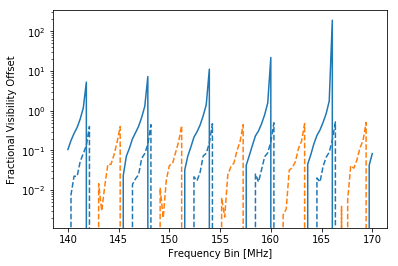

In [131]:
%matplotlib inline

pyplot.semilogy(frequency_range/1e6, (numpy.real(visibilities_grid) - numpy.real(analytic_pixelised))/numpy.real(analytic_pixelised),"C0")
pyplot.semilogy(frequency_range/1e6, (numpy.imag(visibilities_grid) - numpy.imag(analytic_pixelised)/numpy.imag(analytic_pixelised)),"C1")

pyplot.semilogy(frequency_range/1e6, (numpy.real(visibilities_grid) - numpy.real(analytic))/numpy.real(analytic),"C0--")
pyplot.semilogy(frequency_range/1e6, (numpy.imag(visibilities_grid) - numpy.imag(analytic))/numpy.imag(analytic),"C1--")

#pyplot.plot(frequency_range, numpy.real(visibilities_grid),"C0")
#pyplot.plot(frequency_range, numpy.imag(visibilities_grid),"C1")

#pyplot.plot(frequency_range, numpy.real(analytic), "C0--")
#pyplot.plot(frequency_range, numpy.imag(analytic), "C1--")

#pyplot.plot(frequency_range, numpy.real(analytic_pixelised), "C0+")
#pyplot.plot(frequency_range, numpy.imag(analytic_pixelised), "C1+")

pyplot.xlabel("Frequency Bin [MHz]")
pyplot.ylabel("Fractional Visibility Offset")



pyplot.show()